<a href="https://colab.research.google.com/github/tomunizua/firstmodel_summative/blob/master/summative/linear_regression/multivariate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
#import libraries

import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [51]:
df = pd.read_csv('dataset/train.csv')
df.head()

,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


Pre-processing the data

In [52]:
# Convert to datetime format
df['Order_Date'] = pd.to_datetime(df['Order_Date'], dayfirst=True)
df['hour'] = pd.to_datetime(df['Time_Order_picked'], format='%H:%M:%S').dt.hour

# Create time-based features
df['day_of_week'] = df['Order_Date'].dt.dayofweek
df['is_weekend'] = df['day_of_week'] >= 5
df['order_date'] = df['Order_Date'].dt.date
df['month'] = df['Order_Date'].dt.month

# Function to define and check if a date is a holiday
holidays = [
    (1, 1),   # New Year's Day
    (12, 25), # Christmas Day
    (12, 26), # Boxing Day
    (1, 5), # Worker's Day
    (2, 14), # Valentine's Day
    (5, 27), # Children's day
]
def is_holiday(date):
    month_day = (date.month, date.day)
    return int(month_day in holidays)
df['is_holiday'] = df['Order_Date'].apply(is_holiday)

# Function to determine the part of the day
def determine_day_part(hour):
    if 6 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    elif 18 <= hour < 24:
        return 'evening'
    else:
        return 'night'

# Apply the function to create a new 'day_part' column
df['day_part'] = df['hour'].apply(determine_day_part)

# One-hot encode the 'day_part' feature
df = pd.get_dummies(df, columns=['day_part'], drop_first=True)


Aggregating Orders to Define Demand

In [53]:
# Aggregate orders by date and hour
demand = df.groupby(['order_date', 'hour']).size().reset_index(name='demand')

# Merge the demand indicator back into the original dataframe
df = pd.merge(df, demand, on=['order_date', 'hour'])

# Remove the prefix 'conditions ' from 'Weatherconditions' column >>cleaning the data
df['Weatherconditions'] = df['Weatherconditions'].str.replace('conditions ', '')
# Handle NaN values before one-hot encoding
df['Weatherconditions'] = df['Weatherconditions'].fillna('Unknown')

# Perform one-hot encoding
df = pd.get_dummies(df, columns=['Weatherconditions'])

# Identify and covert boolean columns to integers
boolean_columns = df.select_dtypes(include=['bool']).columns
df[boolean_columns] = df[boolean_columns].astype(int)

# Drop unnecessary columns
columns_to_drop = [ 'Delivery_person_ID', 'Order_Date', 'Type_of_vehicle', 'Time_Orderd', 'Festival',
                   'Restaurant_latitude', 'Restaurant_longitude', 'Delivery_location_latitude',
                    'Delivery_location_longitude', 'Delivery_person_Age', 'Delivery_person_Ratings',
                    'Vehicle_condition', 'Time_taken(min)', 'Weatherconditions_Unknown' ]

columns_to_drop = [col for col in columns_to_drop if col in df.columns]
df = df.drop(columns=columns_to_drop)

if 'Weatherconditions_NaN' in df.columns:
    df = df.drop(columns=['Weatherconditions_NaN'])

# Display the first few rows of the modified dataframe
df.head()

,ID,Time_Order_picked,Road_traffic_density,Type_of_order,multiple_deliveries,City,hour,day_of_week,is_weekend,order_date,...,day_part_evening,day_part_morning,day_part_night,demand,Weatherconditions_Cloudy,Weatherconditions_Fog,Weatherconditions_Sandstorms,Weatherconditions_Stormy,Weatherconditions_Sunny,Weatherconditions_Windy
0,0x4607,11:45:00,High,Snack,0,Urban,11,5,1,2022-03-19,...,0,1,0,80,0,0,0,0,1,0
1,0xb379,19:50:00,Jam,Snack,1,Metropolitian,19,4,0,2022-03-25,...,1,0,0,146,0,0,0,1,0,0
2,0x5d6d,08:45:00,Low,Drinks,1,Urban,8,5,1,2022-03-19,...,0,1,0,73,0,0,1,0,0,0
3,0x7a6a,18:10:00,Medium,Buffet,1,Metropolitian,18,1,0,2022-04-05,...,1,0,0,92,0,0,0,0,1,0
4,0x70a2,13:45:00,High,Snack,1,Metropolitian,13,5,1,2022-03-26,...,0,0,0,29,1,0,0,0,0,0


Graphs / Visualizations

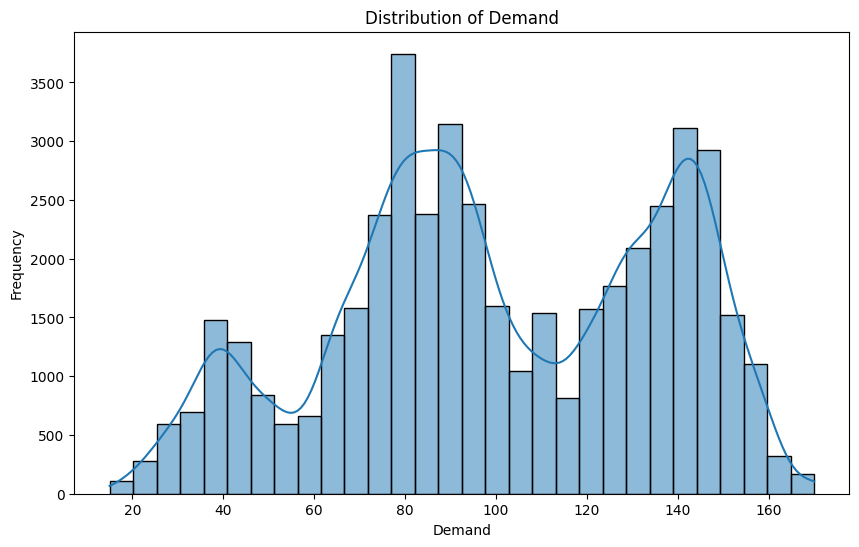

In [54]:
# Visualization 1: Histogram

plt.figure(figsize=(10, 6))
sns.histplot(df['demand'], bins=30, kde=True)
plt.title('Distribution of Demand')
plt.xlabel('Demand')
plt.ylabel('Frequency')
plt.show()

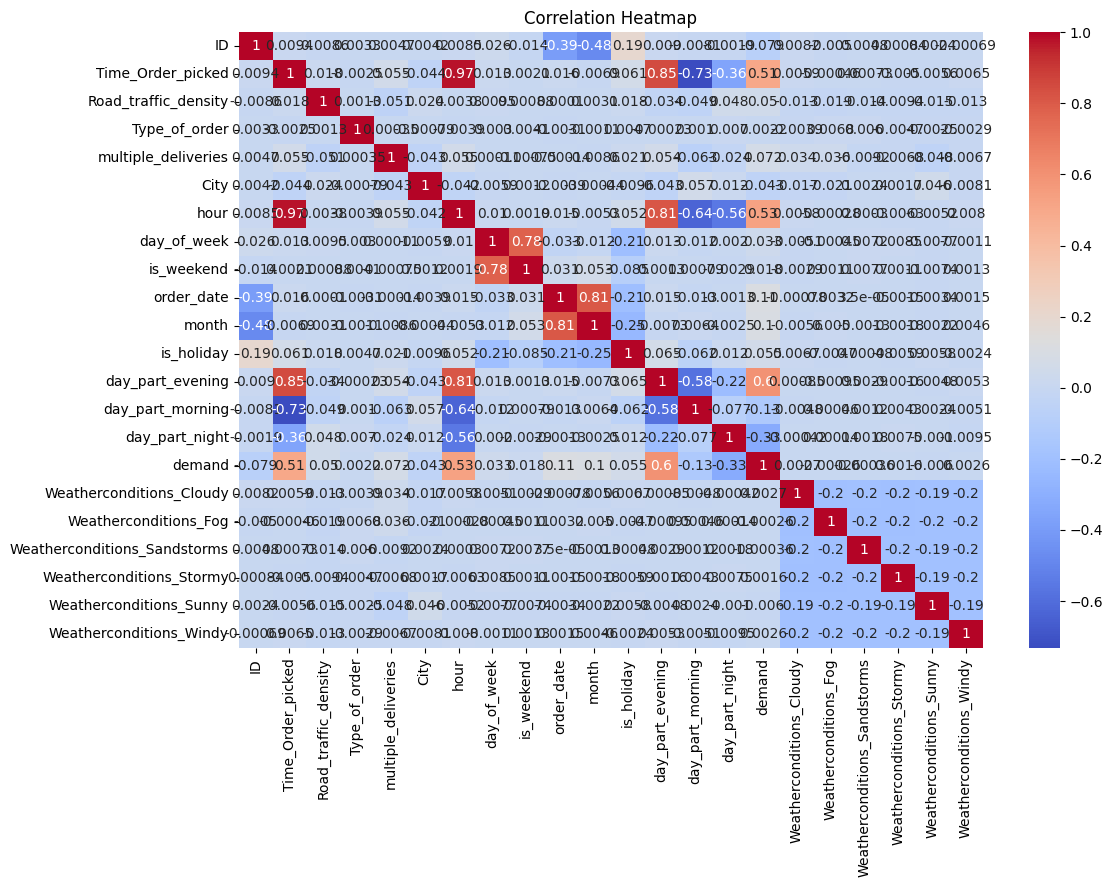

In [90]:
# Visualization 2: Correlation Heatmap

# Exclude non-numeric columns
numeric_df = df.select_dtypes(include=['number'])
# Calculate the correlation matrix
corr_matrix = numeric_df.corr()
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

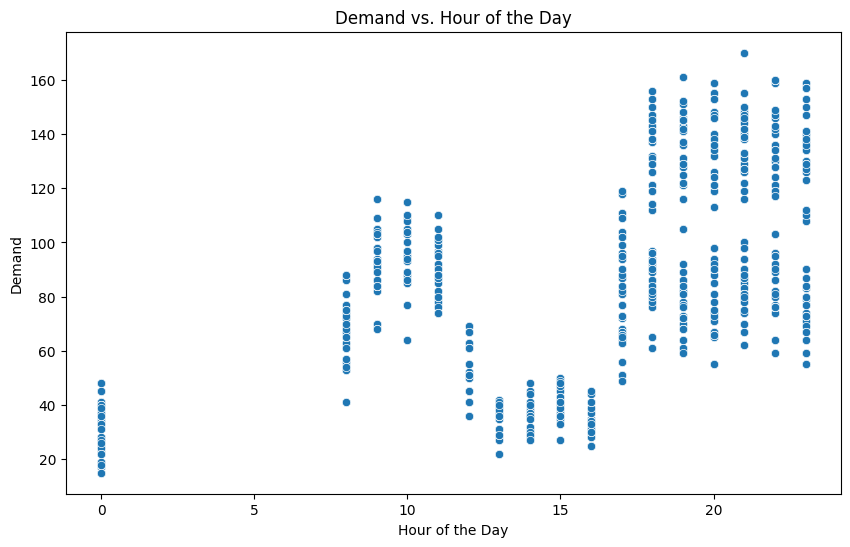

In [56]:
# Visualization 3: Scatterplot

# Scatterplot of Demand vs. Hour of the Day
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['hour'], y=df['demand'])
plt.title('Demand vs. Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Demand')
plt.show()

Preparing the Data for Modeling

In [58]:
#Check and convert data types
for col in df.columns:
   if df[col].dtype == 'object':
       df[col] = df[col].astype('category').cat.codes

# Define features (X) and target (Y)
X = df.drop('demand', axis=1)
Y = df['demand']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Verify the data types after preprocessing
print(X_train.dtypes)


ID                              int32
Time_Order_picked               int16
Road_traffic_density             int8
Type_of_order                    int8
multiple_deliveries              int8
City                             int8
hour                            int32
day_of_week                     int32
is_weekend                      int64
order_date                       int8
month                           int32
is_holiday                      int64
day_part_evening                int64
day_part_morning                int64
day_part_night                  int64
Weatherconditions_Cloudy        int64
Weatherconditions_Fog           int64
Weatherconditions_Sandstorms    int64
Weatherconditions_Stormy        int64
Weatherconditions_Sunny         int64
Weatherconditions_Windy         int64
dtype: object


In [59]:
# Initialize and train the LinearRegression model
lr_sklearn = LinearRegression()
lr_sklearn.fit(X_train, Y_train)


LinearRegression()

In [60]:
# Predict on the test set
Y_pred_lr = lr_sklearn.predict(X_test)

# Calculate the Mean Squared Error (MSE)
rmse_lr = root_mean_squared_error(Y_test, Y_pred_lr)
print('Linear Regression Mean Squared Error:', rmse_lr)

Linear Regression Mean Squared Error: 25.867547467135886


In [61]:
# Initialize and train the DecisionTreeRegressor model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, Y_train)
# Predict on the test set
Y_pred_dt = dt_model.predict(X_test)
# Calculate the Mean Squared Error (MSE)
rmse_dt = root_mean_squared_error(Y_test, Y_pred_dt)
print('Decision Tree RMSE:', rmse_dt)

Decision Tree RMSE: 0.39724349033433615


In [62]:
# Initialize and train the RandomForestRegressor model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, Y_train)
# Predict on the test set
Y_pred_rf = rf_model.predict(X_test)
# Calculate the Mean Squared Error (MSE)
rmse_rf = root_mean_squared_error(Y_test, Y_pred_rf)
print('Random Forest RMSE:', rmse_rf)

Random Forest RMSE: 0.4958972258029405


In [63]:
# Sorting by RMSE
model_rank = {
    'Linear Regression': rmse_lr,
    'Decision Tree': rmse_dt,
    'Random Forest': rmse_rf
}

model_rank = dict(sorted(model_rank.items(), key=lambda item: item[1]))

print("Model Ranking from best to worst performance: ")
for model, rmse in model_rank.items():
    print(f"{model}: {rmse:.4f}")

Model Ranking from best to worst performance: 
Decision Tree: 0.3972
Random Forest: 0.4959
Linear Regression: 25.8675


In [64]:
# Identify the best model
best_model = None
best_rmse = min(rmse_lr, rmse_dt, rmse_rf)

if best_rmse == rmse_lr:
    best_model = lr_sklearn
elif best_rmse == rmse_dt:
    best_model = dt_model
else:
    best_model = rf_model

# Save the best model to a file
joblib.dump(best_model, 'best_model.pkl')
print('Best model saved with RMSE:', best_rmse)


Best model saved with RMSE: 0.39724349033433615


In [65]:
# Load the saved model
model = joblib.load('best_model.pkl')

# Example input data (one row of the test dataset)
input_data = pd.DataFrame([X_test.iloc[0]], columns=X.columns)

# Make a prediction
prediction = model.predict(input_data)
print('Predicted Demand for one data point:', prediction)


Predicted Demand for one data point: [119.]


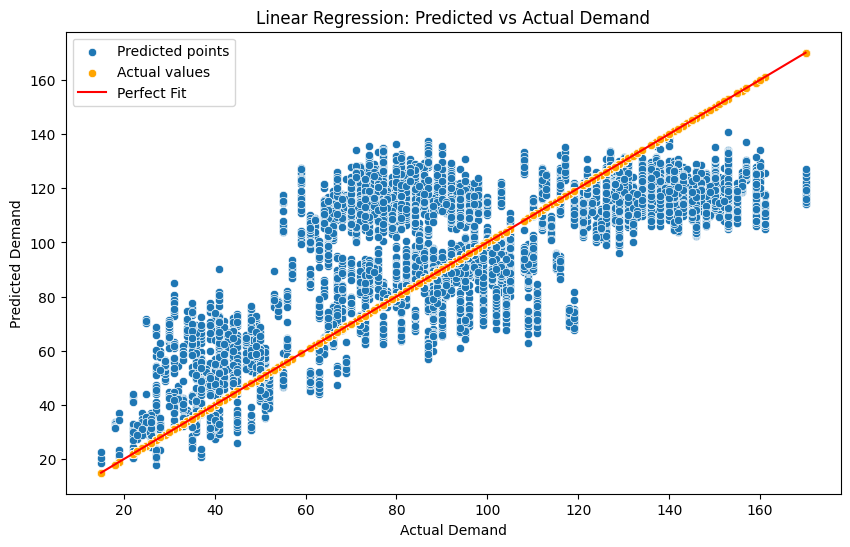

In [83]:
# Scatter plot of Actual vs Predicted values for Linear Regression
plt.figure(figsize=(10, 6))
sns.scatterplot(x=Y_test, y=Y_pred_lr, label='Predicted points')
sns.scatterplot(x=Y_test, y=Y_test, color='orange', label='Actual values')
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', label='Perfect Fit')
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.title('Linear Regression: Predicted vs Actual Demand')
plt.legend()
plt.show()

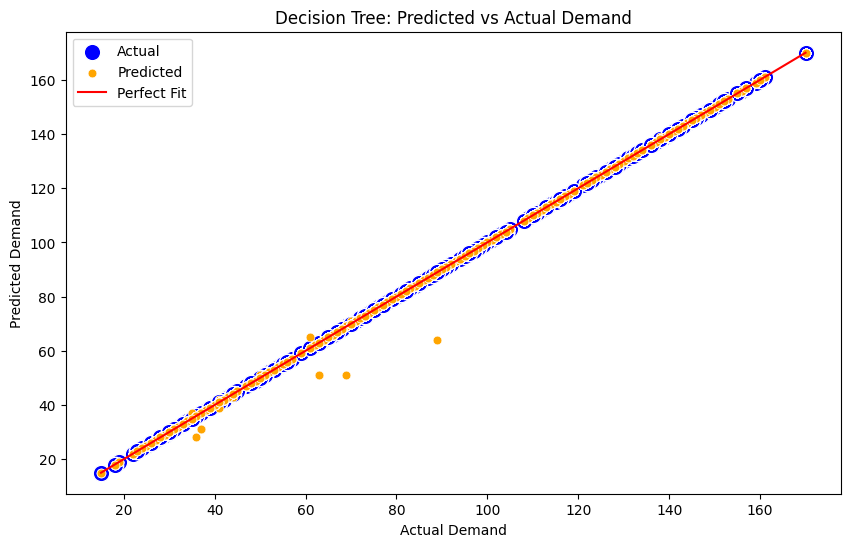

In [81]:
# Predicting on the whole test set for visualization
Y_pred_dt_full = dt_model.predict(X_test)

# Scatter plot of Actual vs Predicted values for Decision Tree
plt.figure(figsize=(10, 6))

# Actual values
sns.scatterplot(x=Y_test, y=Y_test, color='blue', label='Actual', s=140)

# Predicted values
sns.scatterplot(x=Y_test, y=Y_pred_dt_full, color='orange', label='Predicted', s=40)

plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], color='red', label='Perfect Fit')
plt.xlabel('Actual Demand')
plt.ylabel('Predicted Demand')
plt.title('Decision Tree: Predicted vs Actual Demand')
plt.legend()
plt.show()
